# Midterm: Snake Emoji
## Research Question: Where do gaps in transit access to grocery stores exist for residents ages 65+ in the city of Los Angeles?
Group Members: Adriana Ochoa, Carolyn Pugh, Monisha Reginald, Lucy Briggs

For my segment of this midterm, I will be creating maps of the population density of residents age 65 and up by block group within the City of LA. I will be using age data from the [American Community Survey](https://www.socialexplorer.com/reports/socialexplorer/en/report/0cc0f56c-9d1c-11ed-be9e-e30303f780e8), Census Block Group Boundaries from [LA City GeoHub](https://geohub.lacity.org/datasets/lacounty::census-block-groups-2020/about), and the City of Los Angeles Boundary from [LA City GeoHub](https://geohub.lacity.org/datasets/city-boundary/explore?location=34.019779%2C-118.412043%2C10.96). 


This week I will work on finalizing the basemaps for our midterm presentation. Additionally, I will attempt to create some charts for presentation.

# Part 1: Create a Normalized Map of Age 65+ Population by Block Group

Although we have a map of the density of seniors by block group, we want to normalize this data over the entire population so we can see what percentage of each block group is Seniors. 

In [1]:
#libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import fiona 
import numpy as np
import math

## Importing age data
From here, we want a normalized age data table with percent seniors/ total population. Let's start with some data exporlation.

In [2]:
df = pd.read_csv('age.csv')
df.head(5)
df.columns

Index(['Geo_FIPS', 'Geo_QName', 'Geo_FILEID', 'Geo_STUSAB', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_LOGRECNO', 'Geo_US', 'Geo_REGION', 'Geo_DIVISION',
       'Geo_STATECE', 'Geo_STATE', 'Geo_COUNTY', 'Geo_COUSUB', 'Geo_PLACE',
       'Geo_TRACT', 'Geo_BLKGRP', 'Geo_CONCIT', 'Geo_AIANHH', 'Geo_AIANHHFP',
       'Geo_AIHHTLI', 'Geo_AITSCE', 'Geo_AITS', 'Geo_ANRC', 'Geo_CBSA',
       'Geo_CSA', 'Geo_METDIV', 'Geo_MACC', 'Geo_MEMI', 'Geo_NECTA',
       'Geo_CNECTA', 'Geo_NECTADIV', 'Geo_UA', 'Geo_UACP', 'Geo_CDCURR',
       'Geo_SLDU', 'Geo_SLDL', 'Geo_VTD', 'Geo_ZCTA3', 'Geo_ZCTA5',
       'Geo_SUBMCD', 'Geo_SDELM', 'Geo_SDSEC', 'Geo_SDUNI', 'Geo_UR',
       'Geo_PCI', 'Geo_TAZ', 'Geo_UGA', 'Geo_PUMA5', 'Geo_PUMA1', 'Geo_GEOID',
       'Geo_NAME', 'Geo_BTTR', 'Geo_BTBG', 'Geo_PLACESE', 'SE_A01001_001',
       'SE_A01001_002', 'SE_A01001_003', 'SE_A01001_004', 'SE_A01001_005',
       'SE_A01001_006', 'SE_A01001_007', 'SE_A01001_008', 'SE_A01001_009',
       'SE_A01001_010', 'SE_A01001_011

The "Total Population" Column is 'SE_A01001_001' According to the [data dictionary](https://www.socialexplorer.com/data/ACS2021_5yr/metadata/?ds=SE)

# Fixing Geo_FIPS leading zero

This will allow us to join the data with the spatial block boundaries using a primary key. 

In [3]:
df.Geo_FIPS.head()

0    60014001001
1    60014001002
2    60014002001
3    60014002002
4    60014003001
Name: Geo_FIPS, dtype: int64

Specify that Geo FIPS is a string so it doesn't drop the leading zero

In [4]:
#specify geofips as a string
df = pd.read_csv('age.csv',
                 dtype = 
                 {
                     'Geo_FIPS':str,
                     'Geo_STATE':str, 
                     'Geo_COUNTY':str
                 }
                )

In [5]:
df.head(5)

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A01001_004,SE_A01001_005,SE_A01001_006,SE_A01001_007,SE_A01001_008,SE_A01001_009,SE_A01001_010,SE_A01001_011,SE_A01001_012,SE_A01001_013
0,060014001001,"Block Group 1, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11947,NaN,NaN,NaN,...,243,57,98,221,111,395,228,214,116,67
1,060014001002,"Block Group 2, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11948,NaN,NaN,NaN,...,29,19,14,121,186,139,311,226,95,83
2,060014002001,"Block Group 1, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11949,NaN,NaN,NaN,...,52,32,31,115,125,117,123,232,70,17
3,060014002002,"Block Group 2, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11950,NaN,NaN,NaN,...,38,22,30,310,155,111,91,62,82,11
4,060014003001,"Block Group 1, Census Tract 4003, Alameda Coun...",ACSSF,ca,150,0,11951,NaN,NaN,NaN,...,41,37,39,225,147,173,137,141,67,0


In [6]:
#confirming it changed to a string
df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25607 entries, 0 to 25606
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Geo_FIPS       25607 non-null  object 
 1   Geo_QName      25607 non-null  object 
 2   Geo_FILEID     25607 non-null  object 
 3   Geo_STUSAB     25607 non-null  object 
 4   Geo_SUMLEV     25607 non-null  int64  
 5   Geo_GEOCOMP    25607 non-null  int64  
 6   Geo_LOGRECNO   25607 non-null  int64  
 7   Geo_US         0 non-null      float64
 8   Geo_REGION     0 non-null      float64
 9   Geo_DIVISION   0 non-null      float64
 10  Geo_STATECE    0 non-null      float64
 11  Geo_STATE      25607 non-null  object 
 12  Geo_COUNTY     25607 non-null  object 
 13  Geo_COUSUB     0 non-null      float64
 14  Geo_PLACE      0 non-null      float64
 15  Geo_TRACT      25607 non-null  int64  
 16  Geo_BLKGRP     25607 non-null  int64  
 17  Geo_CONCIT     0 non-null      float64
 18  Geo_AI

The leading zero is there, so we won't run in to issues when joining. 

# Deleting Null Columns

There are plenty of null columns that we don't need for this analysis. 

In [7]:
df.columns[df.isna().all()].tolist()

['Geo_US',
 'Geo_REGION',
 'Geo_DIVISION',
 'Geo_STATECE',
 'Geo_COUSUB',
 'Geo_PLACE',
 'Geo_CONCIT',
 'Geo_AIANHH',
 'Geo_AIANHHFP',
 'Geo_AIHHTLI',
 'Geo_AITSCE',
 'Geo_AITS',
 'Geo_ANRC',
 'Geo_CBSA',
 'Geo_CSA',
 'Geo_METDIV',
 'Geo_MACC',
 'Geo_MEMI',
 'Geo_NECTA',
 'Geo_CNECTA',
 'Geo_NECTADIV',
 'Geo_UA',
 'Geo_UACP',
 'Geo_CDCURR',
 'Geo_SLDU',
 'Geo_SLDL',
 'Geo_VTD',
 'Geo_ZCTA3',
 'Geo_ZCTA5',
 'Geo_SUBMCD',
 'Geo_SDELM',
 'Geo_SDSEC',
 'Geo_SDUNI',
 'Geo_UR',
 'Geo_PCI',
 'Geo_TAZ',
 'Geo_UGA',
 'Geo_PUMA5',
 'Geo_PUMA1',
 'Geo_BTTR',
 'Geo_BTBG',
 'Geo_PLACESE']

In [8]:
df = df.dropna(axis=1,how='all')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25607 entries, 0 to 25606
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Geo_FIPS       25607 non-null  object
 1   Geo_QName      25607 non-null  object
 2   Geo_FILEID     25607 non-null  object
 3   Geo_STUSAB     25607 non-null  object
 4   Geo_SUMLEV     25607 non-null  int64 
 5   Geo_GEOCOMP    25607 non-null  int64 
 6   Geo_LOGRECNO   25607 non-null  int64 
 7   Geo_STATE      25607 non-null  object
 8   Geo_COUNTY     25607 non-null  object
 9   Geo_TRACT      25607 non-null  int64 
 10  Geo_BLKGRP     25607 non-null  int64 
 11  Geo_GEOID      25607 non-null  object
 12  Geo_NAME       25607 non-null  object
 13  SE_A01001_001  25607 non-null  int64 
 14  SE_A01001_002  25607 non-null  int64 
 15  SE_A01001_003  25607 non-null  int64 
 16  SE_A01001_004  25607 non-null  int64 
 17  SE_A01001_005  25607 non-null  int64 
 18  SE_A01001_006  25607 non-n

We dropped a lot of null columns. We still have 25 non-null columns, most relate to age group.

# Create a "Total Senior Populaton" Column
We want a column of "totals" that is a sum of columns ending in 011, 012, and 013, because these represent the age groups (65+) that we are concerned with.

In [9]:
df['Total Senior Pop']=df.iloc[:,[23,24,25]].sum(axis=1)

In [10]:
df.head(5)

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_STATE,Geo_COUNTY,Geo_TRACT,...,SE_A01001_005,SE_A01001_006,SE_A01001_007,SE_A01001_008,SE_A01001_009,SE_A01001_010,SE_A01001_011,SE_A01001_012,SE_A01001_013,Total Senior Pop
0,060014001001,"Block Group 1, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11947,06,001,400100,...,57,98,221,111,395,228,214,116,67,397
1,060014001002,"Block Group 2, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11948,06,001,400100,...,19,14,121,186,139,311,226,95,83,404
2,060014002001,"Block Group 1, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11949,06,001,400200,...,32,31,115,125,117,123,232,70,17,319
3,060014002002,"Block Group 2, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11950,06,001,400200,...,22,30,310,155,111,91,62,82,11,155
4,060014003001,"Block Group 1, Census Tract 4003, Alameda Coun...",ACSSF,ca,150,0,11951,06,001,400300,...,37,39,225,147,173,137,141,67,0,208


Now we have a column showing the total number of resdents age 65+. 

# Which columns to keep?
Look at data dictionary and figure out which columns to keep. 

link to data dictionary: https://www.socialexplorer.com/data/ACS2021_5yr/metadata/?ds=SE

Only keep FIPS, Total Population, and the age groups we are interested in (65+), as well as the Total Senior Population column that we created.  

In [11]:
columns_to_keep = ['Geo_FIPS',
                   'SE_A01001_001',     
                   'SE_A01001_011',
                   'SE_A01001_012',
                   'SE_A01001_013',
                  'Total Senior Pop']
#save in a new dataframe
df2 = df[columns_to_keep]
df2.head()

,Geo_FIPS,SE_A01001_001,SE_A01001_011,SE_A01001_012,SE_A01001_013,Total Senior Pop
0,060014001001,1963,214,116,67,397
1,060014001002,1361,226,95,83,404
2,060014002001,1029,232,70,17,319
3,060014002002,1009,62,82,11,155
4,060014003001,1122,141,67,0,208


Now we have a table showing the total population of the senior groups we are interested in, as well as the total general population of each block group. This can be used to normalize the senior population data and allow us to look at percentages of seniors for each block group. 

# Renaming Columns
Rename the columns for easier reading

In [12]:
columns = list(df2)
columns

['Geo_FIPS',
 'SE_A01001_001',
 'SE_A01001_011',
 'SE_A01001_012',
 'SE_A01001_013',
 'Total Senior Pop']

In [13]:
#copy and paste list above, replace vals with desired names
df2.columns = ['FIPS',
               'Total Pop',
               'Age 65-74',
               'Age 75-84', 
               'Age 85+', 
               'Total Senior Pop']
df2.sample(5)

,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop
24857,061070041033,971,0,0,0,0
20928,060790102072,1957,197,186,42,425
13133,060590877011,1647,112,63,54,229
21838,060830028091,946,95,79,0,174
14617,060650432292,1958,0,50,21,71


# Creating a "Percentage Seniors" Column

For mapping, we want our data to be normalized across the entire population, so that increased density of seniors doesn't just reflect density as a whole population. To do this, we want to find the "rate" of senior population, so we will use the formula pct seniors = 100(senior pop/total pop). 

In [14]:
df2['Pct Seniors'] = 100*(df2['Total Senior Pop']/df2['Total Pop']).fillna(0)
df2.sort_values('Pct Seniors', inplace=True, ascending=False)
df2.head(10)

/tmp/ipykernel_579/2307236421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Pct Seniors'] = 100*(df2['Total Senior Pop']/df2['Total Pop']).fillna(0)
/tmp/ipykernel_579/2307236421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_values('Pct Seniors', inplace=True, ascending=False)


,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Pct Seniors
20399,060759805011,104,5,63,36,104,100.000000
10559,060379800331,13,13,0,0,13,100.000000
10409,060379200311,18,18,0,0,18,100.000000
467,060014251012,13,0,13,0,13,100.000000
23907,060971524021,311,39,122,148,309,99.356913
16377,060690006024,47,10,13,23,46,97.872340
1852,060133511041,539,242,175,108,525,97.402597
19181,060730176013,1284,54,550,645,1249,97.274143
15272,060650514013,928,304,594,0,898,96.767241
15270,060650514011,1283,623,496,117,1236,96.336711


Now we can see that several block groups are made up of 100% seniors. Let's see if all of these are actually within the City of LA or just the County. 

# Clipping

In [15]:
import geopandas as gpd

We want to clip the County boundaries down to just the City of LA. First, read a dataset of all the municipalities within LA county. 

In [16]:
cities=gpd.read_file('City_Boundaries.geojson')
cities.head(5)

,OBJECTID,CITY_NAME,CITY_LABEL,ABBR,OF_AREA_SM,CITY_TYPE,FEAT_TYPE,COLOR_EGIS,URL,PHONE,last_edited_date,ShapeSTArea,ShapeSTLength,geometry
0,3,Redondo Beach,Redondo Beach,RBCH,6.349,City,Breakwater,"Pink - RGB 255,190,232",www.redondo.org,3103721171,2022-07-20 00:08:28+00:00,2.483437e+05,7484.640344,"POLYGON ((-118.39951 33.84377, -118.39952 33.8..."
1,4,Long Beach,Long Beach,LB,50.309,City,Water,"Purple - RGB 185,185,250",www.longbeach.gov,5625706555,2022-07-20 00:08:28+00:00,4.000260e+06,20369.924519,"POLYGON ((-118.21061 33.72181, -118.21064 33.7..."
2,5,Redondo Beach,Redondo Beach,RBCH,6.349,City,Breakwater,"Pink - RGB 255,190,232",www.redondo.org,3103721171,2022-07-20 00:08:28+00:00,9.452611e+03,701.117043,"POLYGON ((-118.39150 33.83193, -118.39160 33.8..."
3,6,Los Angeles,Los Angeles,LA,468.852,City,Breakwater,"Gray - RGB 178,178,178",www.lacity.org,2134733231,2022-07-20 00:08:28+00:00,2.857692e+05,17391.983014,"POLYGON ((-118.26566 33.70405, -118.26574 33.7..."
4,7,Long Beach,Long Beach,LB,50.309,City,Breakwater,"Purple - RGB 185,185,250",www.longbeach.gov,5625706555,2022-07-20 00:08:28+00:00,1.097324e+05,5448.776853,"POLYGON ((-118.11850 33.74278, -118.11855 33.7..."


Query to subset just the City of LA. 

In [17]:
lacity=cities.query("CITY_NAME == 'Los Angeles'").copy()

Eventually, we want to join our census data to block groups within the City of LA. First, let's clip the block groups down to the City level, then we can join it to the census data. 

In [18]:
#finding a geojson file for census blocks 
blocks = gpd.read_file('Census_Block_Groups_2020.geojson')
blocks.size

46116

Clip the county down to the city boundary

In [19]:
blocks_clip = gpd.clip(blocks, lacity)
blocks_clip.size

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


20678

Now, the block are only shown at the city level, not across the whole county. Let's continue to clean up the df. 

In [20]:
#subset only the columns we need (fips, area, and geometry)
blocks_clip = blocks_clip [['BG20', 'ShapeSTArea', 'geometry']]
blocks_clip.head(5)

,BG20,ShapeSTArea,geometry
2456,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9..."
2449,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713..."
2448,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9..."
2447,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9..."
2435,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9..."


Now we want to join the census block boundaries within the city of LA to our census data. We have to create a FIPS column for the block boundaries, since they only show the block group number in "BG20". 

In [21]:
# create a FIPS column
blocks_clip['FIPS'] ='06' + '037' + blocks_clip['BG20']

In [22]:
blocks_clip.head()
#ignore error!

,BG20,ShapeSTArea,geometry,FIPS
2456,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",060372742023
2449,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713...",060372739025
2448,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",060372739024
2447,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023
2435,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9...",060372735023


The FIPS code worked, now we have a primary key to merge our Census data. Once it is merged, it will have the boundary geometry attached and will be mappable. 

In [23]:
#join the ACS data with the geographic boundaries
blocks_age = blocks_clip.merge(df2,on="FIPS")

In [24]:
blocks_age.head(5)

,BG20,ShapeSTArea,geometry,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Pct Seniors
0,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",060372742023,740,0,0,13,13,1.756757
1,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713...",060372739025,763,120,38,0,158,20.707733
2,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",060372739024,998,90,10,0,100,10.020040
3,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023,1098,92,137,11,240,21.857923
4,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9...",060372735023,923,29,40,0,69,7.475623


Now we have a mappable df of the total senior pop and percent population. 

## Creating columns for Area of Block Group and Population Density

In addition to percent of seniors, we want to see how many seniors per square mile are in each block group. To do that, we have to figure out the square mile area of each block group. 
The column ShapeSTArea shows the area of each block group shape, but it is in units of square meters. To change this to square miles, we will divide each by [2,590,000](https://www.google.com/search?q=square+meters+to+square+miles&rlz=1C1CHBF_enUS878US878&oq=square&aqs=chrome.0.69i59j69i57j0i131i433i512j0i433i512j0i131i433i512l2j69i60l2.994j0j7&sourceid=chrome&ie=UTF-8)

In [25]:
blocks_age['Square Miles'] = blocks_age['ShapeSTArea']/2590000
blocks_age.head(5)

,BG20,ShapeSTArea,geometry,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Pct Seniors,Square Miles
0,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",060372742023,740,0,0,13,13,1.756757,0.403581
1,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713...",060372739025,763,120,38,0,158,20.707733,1.981346
2,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",060372739024,998,90,10,0,100,10.020040,0.718775
3,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023,1098,92,137,11,240,21.857923,0.470335
4,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9...",060372735023,923,29,40,0,69,7.475623,1.879684


Now we have a column with the square mileage of each census block group. 

Now, for population density: Divide the total senior pop by the square mile of the block

In [26]:
blocks_age['Pop Density'] = round(blocks_age['Total Senior Pop']/blocks_age['Square Miles']) #rounding so we get whole numbers
blocks_age.head(5)

,BG20,ShapeSTArea,geometry,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Pct Seniors,Square Miles,Pop Density
0,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",060372742023,740,0,0,13,13,1.756757,0.403581,32.0
1,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713...",060372739025,763,120,38,0,158,20.707733,1.981346,80.0
2,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",060372739024,998,90,10,0,100,10.020040,0.718775,139.0
3,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023,1098,92,137,11,240,21.857923,0.470335,510.0
4,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9...",060372735023,923,29,40,0,69,7.475623,1.879684,37.0


Now we have a df that shows percent of seniors in each block group and number of seniors per square mile in each block group. Let's see how the two compare on maps. 

# Mapping

First, map the percentage of seniors over the total population. 

<AxesSubplot: >

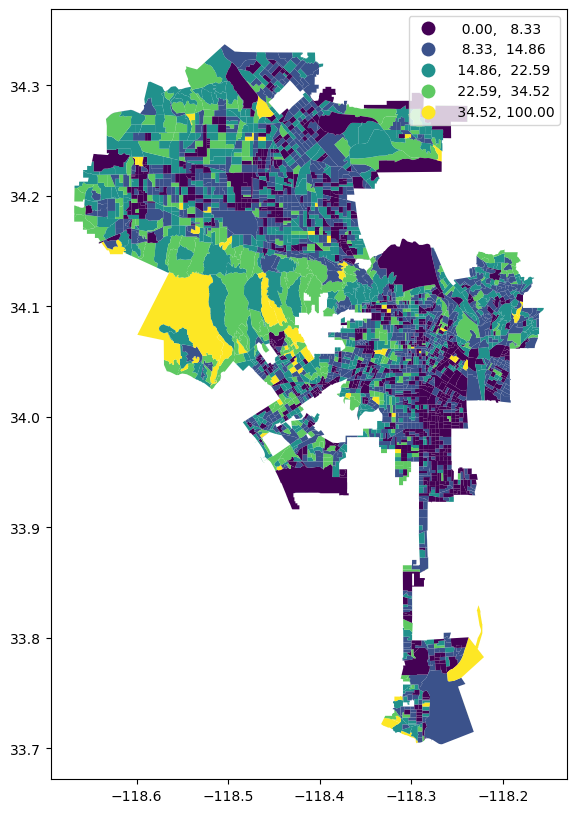

In [27]:
blocks_age.plot(figsize=(12,10),
                column='Pct Seniors',
                legend=True,
                scheme='NaturalBreaks')

This pattern shows that seniors might be more densly populated in the hills, a less dense area design-wise. Zooming in could be helpful.

Now, compare this to the population density of seniors. 

<AxesSubplot: >

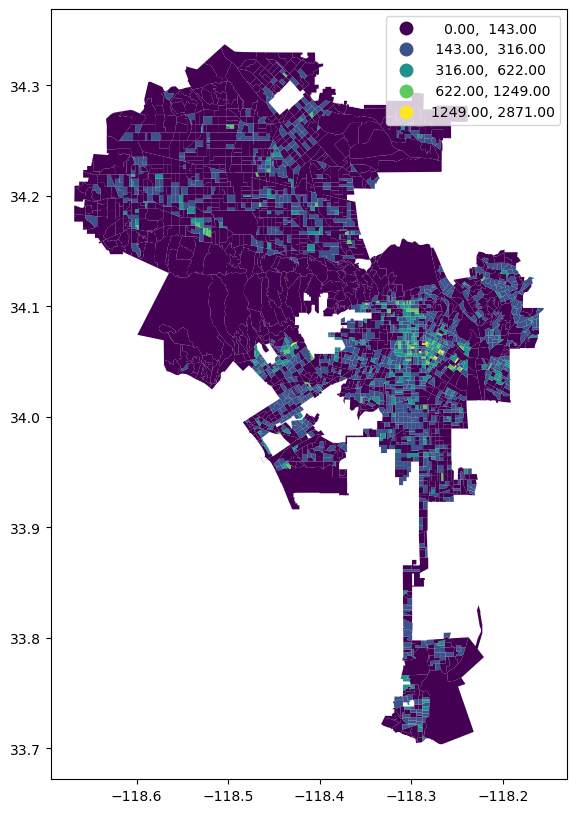

In [28]:
blocks_age.plot(figsize=(12,10),
                column='Pop Density',
                legend=True,
                scheme='NaturalBreaks')

It is likely that the patterns here just reflect the overall population density per square mile, as smaller area block groups may have higher populations downtown. We should propbably use the "percent seniors" map to better express the different densities of seniors. 

In [29]:
blocks_age.to_csv('Percent_Senior_Basemap.csv')

# Making a binary map to show the block groups with highest percentages of seniors

Rather than a chloropleth map, I would like to create a map of the city that only shows the census block groups that have the highest percentage of seniors. To do this, first we have to create a new column that shows the different categories of percentage. For example, 0-10%, 10-20%, etc. So if a tract has 14% seniors, it will fall into the 10-20% category. Then, we will create a loop that outputs binary maps for each interval category. 

1. Create a new column with categories for pct seniors. 

In [30]:
#new column
blocks_age['pctcat'] = ''
blocks_age.head(10)

,BG20,ShapeSTArea,geometry,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Pct Seniors,Square Miles,Pop Density,pctcat
0,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",060372742023,740,0,0,13,13,1.756757,0.403581,32.0,
1,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713...",060372739025,763,120,38,0,158,20.707733,1.981346,80.0,
2,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",060372739024,998,90,10,0,100,10.020040,0.718775,139.0,
3,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023,1098,92,137,11,240,21.857923,0.470335,510.0,
4,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9...",060372735023,923,29,40,0,69,7.475623,1.879684,37.0,
5,2735021,1.776503e+06,"POLYGON ((-118.46412 33.98848, -118.46575 33.9...",060372735021,843,44,29,0,73,8.659549,0.685909,106.0,
6,2735022,1.822574e+06,"POLYGON ((-118.46441 33.98924, -118.46527 33.9...",060372735022,935,145,11,0,156,16.684492,0.703696,222.0,
7,2734031,7.869489e+06,"POLYGON ((-118.48162 33.99653, -118.48145 33.9...",060372734031,737,34,55,33,122,16.553596,3.038413,40.0,
8,2734032,7.063375e+05,"POLYGON ((-118.47451 33.99271, -118.47438 33.9...",060372734032,537,0,0,19,19,3.538175,0.272717,70.0,
9,7021024,1.803181e+06,"MULTIPOLYGON (((-118.47839 33.99813, -118.4784...",060377021024,1247,138,27,0,165,13.231756,0.696209,237.0,


2. Add the interval of choice depending on the value in Pct Seniors using queries

In [31]:
blocks_age.loc[blocks_age['Pct Seniors'].between(0,10), 'pctcat'] = '0%-10%'
blocks_age.loc[blocks_age['Pct Seniors'].between(10,20), 'pctcat'] = '10%-20%'
blocks_age.loc[blocks_age['Pct Seniors'].between(20,40), 'pctcat'] = '20%-40%'
blocks_age.loc[blocks_age['Pct Seniors'] > 40, 'pctcat'] = '40%+'
blocks_age.sample(5)

,BG20,ShapeSTArea,geometry,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Pct Seniors,Square Miles,Pop Density,pctcat
2437,1316002,4.040835e+06,"POLYGON ((-118.55357 34.22020, -118.55356 34.2...",060371316002,1431,73,28,13,114,7.966457,1.560168,73.0,0%-10%
2433,1313001,3.993723e+06,"POLYGON ((-118.51861 34.21204, -118.51967 34.2...",060371313001,1497,84,38,48,170,11.356045,1.541978,110.0,10%-20%
2006,1438011,1.106005e+07,"POLYGON ((-118.38809 34.13967, -118.38801 34.1...",060371438011,2091,110,133,0,243,11.621234,4.270290,57.0,10%-20%
2310,1232052,5.975716e+06,"POLYGON ((-118.37906 34.19394, -118.38015 34.1...",060371232052,1069,34,48,0,82,7.670720,2.307226,36.0,0%-10%
2218,1272202,2.076403e+06,"POLYGON ((-118.45003 34.20571, -118.45003 34.2...",060371272202,1374,80,16,0,96,6.986900,0.801700,120.0,0%-10%


now we have a column that shows each interval category that the percentage falls into. 

3. Make a new list of all unique pctcat

In [32]:
pctcats = blocks_age['pctcat'].unique().tolist()
pctcats

['0%-10%', '20%-40%', '10%-20%', '40%+']

This list shows all of our categories and can be used to create a loop. 

4. Map it with a loop!

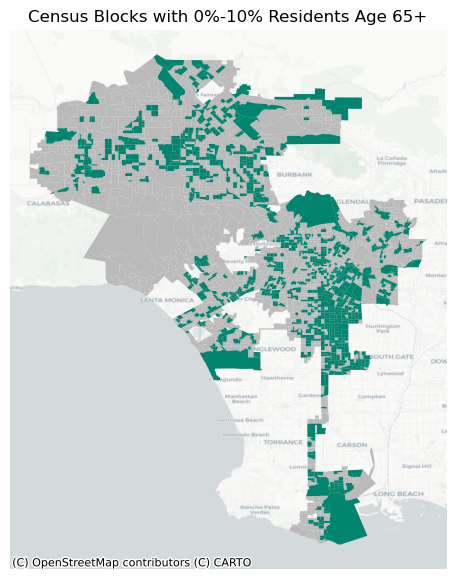

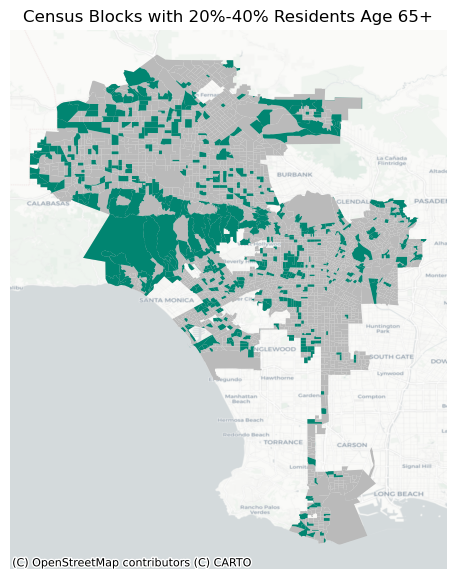

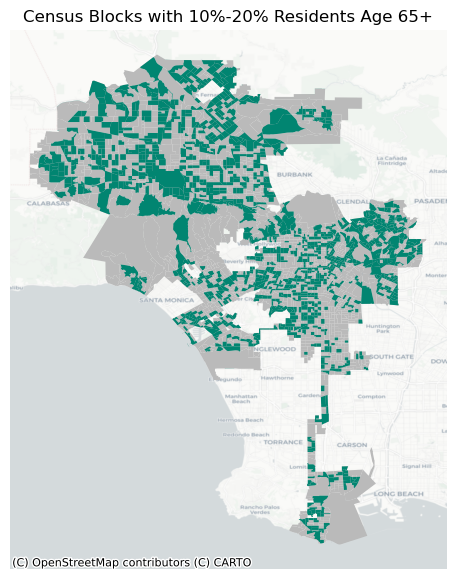

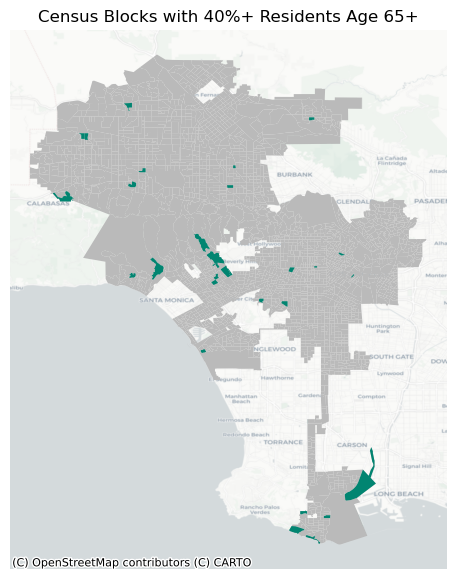

In [33]:
for pct in pctcats:
    fig, ax = plt.subplots(figsize=(7,7))

    # create the map plot
    blocks_age.plot(ax=ax,
            color='#bababa')

    # create the map plot
    blocks_age[blocks_age['pctcat'] == pct].plot(ax=ax,
            # column='pctcat',
            color='#018571')

    # add a title
    ax.set_title('Census Blocks with ' + pct + ' ' + 'Residents Age 65+')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

    # get rid of the axis
    ax.axis('off');

Now we have binary maps of each category of senior density. These can be adjusted to show different categories and percentages. The 40%+ map picks out areas with extremely high concentrations of seniors, and the 20-40% map shows more widespread distribution of seniors. Now, let's plot the different percentages in a single chart.

<AxesSubplot: title={'center': 'Percent Residents age 65+ Per Census Block'}, xlabel='BG20'>

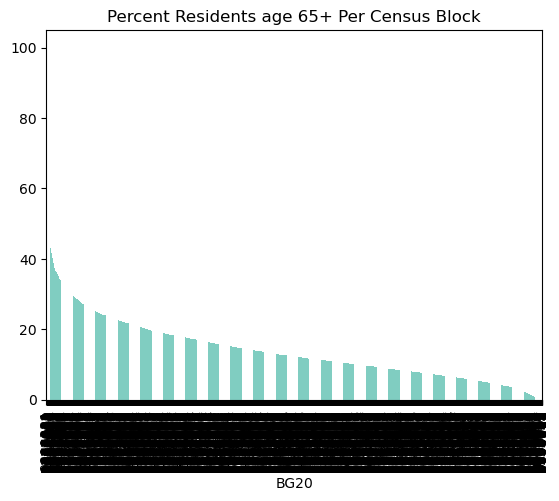

In [38]:
blocks_age.plot.bar(x = 'BG20', 
                    y = 'Pct Seniors', 
                    title = 'Percent Residents age 65+ Per Census Block', 
                    legend = False, 
                    color='#80cdc1')

This chart isn't very useful or readable, but shows what our maps already told us, that most of the groups were under 20% with a few up to 40%+. Let's instead look at the top 10 block groups to see what the highest percentages of seniors are. 

In [40]:
#Sort to see the top groups
blocks_age.sort_values('Pct Seniors', inplace=True, ascending=False)
blocks_age.head()

,BG20,ShapeSTArea,geometry,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Pct Seniors,Square Miles,Pop Density,pctcat
686,9800331,3.083003e+08,"MULTIPOLYGON (((-118.24546 33.76389, -118.2445...",060379800331,13,13,0,0,13,100.000000,119.034875,0.0,40%+
2300,1233043,1.263296e+06,"POLYGON ((-118.40185 34.19032, -118.40210 34.1...",060371233043,971,182,230,197,609,62.718847,0.487759,1249.0,40%+
1423,2075021,6.864472e+05,"POLYGON ((-118.25179 34.04878, -118.25286 34.0...",060372075021,1220,63,516,182,761,62.377049,0.265038,2871.0,40%+
1896,2657021,9.907742e+05,"POLYGON ((-118.42529 34.06636, -118.42558 34.0...",060372657021,1044,198,252,140,590,56.513410,0.382538,1542.0,40%+
573,2975011,2.817318e+07,"POLYGON ((-118.31116 33.71464, -118.31040 33.7...",060372975011,407,175,17,36,228,56.019656,10.877675,21.0,40%+


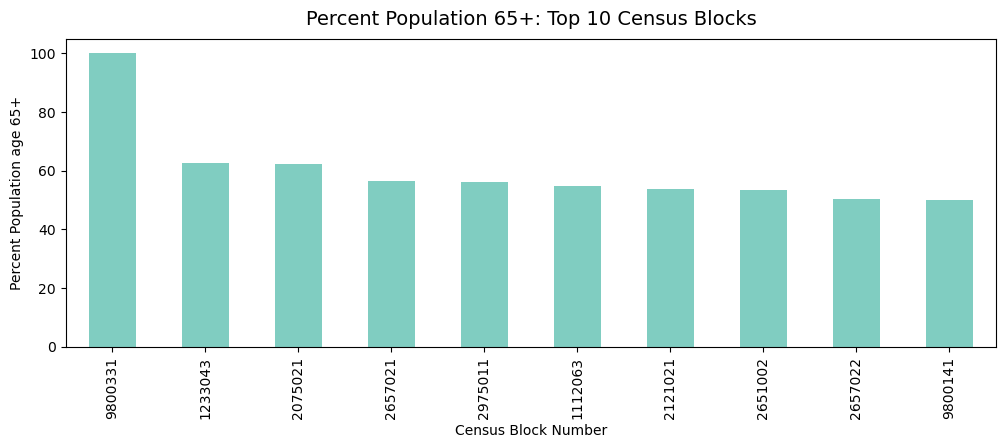

In [41]:
#plot the df
blocks_age.sort_values('Pct Seniors', inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(12,4))

blocks_age[:10].plot.bar(ax=ax,
                                      x='BG20',
                                      y='Pct Seniors',
                                      legend=False,
                                      color='#80cdc1'
                                      )
ax.set_xlabel('Census Block Number') # override x label
ax.set_ylabel('Percent Population age 65+') # override y label
ax.set_title("Percent Population 65+: Top 10 Census Blocks",fontsize=14,pad=10); # multi-line title with padding

Now we see that there is one block group with 100% seniors, and the highest are up to 60% or more seniors. 